## Task 2
### Data set: kddcup.data_10_percent
#### Source: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
## Objective
### Develop an Artificial Neural Network (ANN) in Keras to predict the attack type (namely, values in the last column of the data set). Therefore, it is a multiple classification problem.
## Requirements
#### (1) Use stratified sampling to get 2/3 data for as training data and 1/3 data as test data.
#### (2) You can use Scikit-Learn or other Python libraries for pre-processing and stratified sampling.However, the ANN must be built with the Keras API in TensorFlow.
#### (3) The ANN is a Multi-Layer Perceptron where all hidden layers are fully connected (i.e., denselayers).
#### (4) The training process includes a hyperparameter fine-tunning step. Define a grid including at leastthree hyperparameters: (a) the number of hidden layers, (b) the number of neurons in each layer, and(c) the regularization parameters for L1 and L2. Each hyperparameter has at least two candidate values. All other parameters (e.g., activation functions and learning rates) are up to you.
#### (5) Return the accuracy of testing.

In [1]:
# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
from tensorflow.keras import layers
# importing helper library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading and importing dataset kddcup.data as a csv file. Adding the columns into the dataset header and shuffle the dataset

In [2]:
columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'attack_type'
]
# Set columns to header and import and read data
df = pd.read_csv('kddcup.data',header=None,names=columns)
# Shuffle the dataset to simulate randomness of data
np.random.shuffle(df.values)
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [3]:
# Get rid of the . in attack_type
df['attack_type'] = df.apply(lambda x: x['attack_type'][:-1], axis = 1)

In [4]:
# Get the attack_type unique values
df['attack_type'].unique()

array(['normal', 'buffer_overflow', 'loadmodule', 'perl', 'neptune',
       'smurf', 'guess_passwd', 'pod', 'teardrop', 'portsweep', 'ipsweep',
       'land', 'ftp_write', 'back', 'imap', 'satan', 'phf', 'nmap',
       'multihop', 'warezmaster', 'warezclient', 'spy', 'rootkit'],
      dtype=object)

###  Map the attack_type to different type of intrusion types listed in the KDD CUP 199 Dataset, under data files: training_attack_types

#### There are 5 unique intrusion type: normal, dos, u2r, r21, probe

In [5]:
df['attack_type'] = df['attack_type'].map({
'normal': 'normal',
'back': 'dos',
'buffer_overflow': 'u2r',
'ftp_write': 'r2l',
'guess_passwd': 'r2l',
'imap': 'r2l',
'ipsweep': 'probe',
'land': 'dos',
'loadmodule': 'u2r',
'multihop': 'r2l',
'neptune': 'dos',
'nmap': 'probe',
'perl': 'u2r',
'phf': 'r2l',
'pod': 'dos',
'portsweep': 'probe',
'rootkit': 'u2r',
'satan': 'probe',
'smurf': 'dos',
'spy': 'r2l',
'teardrop': 'dos',
'warezclient': 'r2l',
'warezmaster': 'r2l',
})

In [6]:
# Check for null values
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

### Finding the categorical columns/features for the dataset and plot bar graph to visualise it, and convert it into numeric values.
#### As from the from the graph, the 'service' column seems to have too many distinct unique values and only 3 distinct values is worth looking at, hence i would drop it. 
#### So, after doing the visualising i would map 3 columns('attack_type','protocol_type','flag').


#### 'protocol_type': 'tcp':0,'udp':1,'icmp':2
#### 'flag':'SF':0,'S2':1,'S1':2,'S3':3,'OTH':4,'REJ':5,'RSTO':6,'S0':7,'RSTR':8,'RSTOS0':9,'SH':10
#### 'normal':0,'u2r':1,'dos':2,'r2l':3,'probe':4

In [7]:
#Finding categorical features
num_cols = df._get_numeric_data().columns

cat_cols = list(set(df.columns)-set(num_cols))
cat_cols.remove('attack_type')

cat_cols

['service', 'flag', 'protocol_type']

In [8]:
# Function to plot bar_graph for each categorical features
def bar_graph(feature):
    df[feature].value_counts().plot(kind="bar")

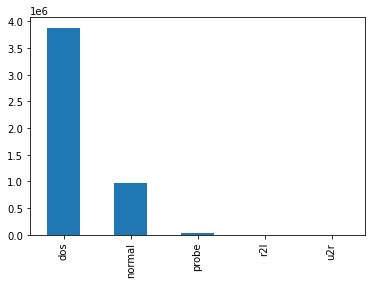

In [9]:
bar_graph('attack_type')

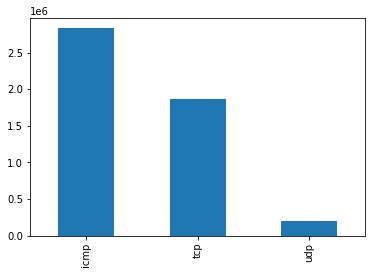

In [10]:
bar_graph('protocol_type')

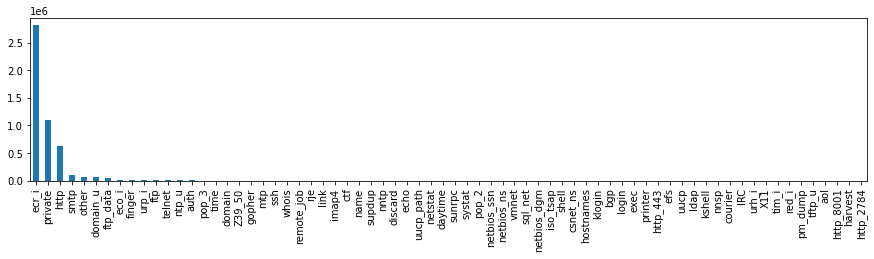

In [11]:
plt.figure(figsize=(15,3))
bar_graph('service')

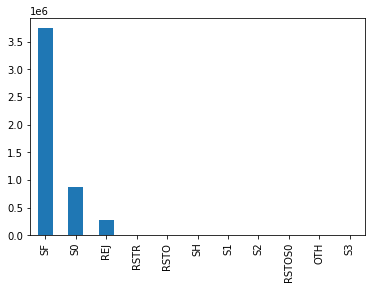

In [12]:
bar_graph('flag')

In [13]:
# get unique values of this columns
print(df['protocol_type'].unique())
print(df['flag'].unique())
print(df['service'].unique())
print(df['attack_type'].unique())

['tcp' 'udp' 'icmp']
['SF' 'S2' 'S1' 'S3' 'OTH' 'REJ' 'RSTO' 'S0' 'RSTR' 'RSTOS0' 'SH']
['http' 'smtp' 'domain_u' 'auth' 'finger' 'telnet' 'eco_i' 'ftp' 'ntp_u'
 'ecr_i' 'other' 'urp_i' 'private' 'pop_3' 'ftp_data' 'netstat' 'daytime'
 'ssh' 'echo' 'time' 'name' 'whois' 'domain' 'mtp' 'gopher' 'remote_job'
 'rje' 'ctf' 'supdup' 'link' 'systat' 'discard' 'X11' 'shell' 'login'
 'imap4' 'nntp' 'uucp' 'pm_dump' 'IRC' 'Z39_50' 'netbios_dgm' 'ldap'
 'sunrpc' 'courier' 'exec' 'bgp' 'csnet_ns' 'http_443' 'klogin' 'printer'
 'netbios_ssn' 'pop_2' 'nnsp' 'efs' 'hostnames' 'uucp_path' 'sql_net'
 'vmnet' 'iso_tsap' 'netbios_ns' 'kshell' 'urh_i' 'http_2784' 'harvest'
 'aol' 'tftp_u' 'http_8001' 'tim_i' 'red_i']
['normal' 'u2r' 'dos' 'r2l' 'probe']


In [14]:
# Feature mapping 
df['protocol_type'] = df['protocol_type'].map({'icmp':0,'tcp':1,'udp':2}).astype(int)
df['flag']=df['flag'].map({'SF':0,'S0':1,'REJ':2,'RSTR':3,'RSTO':4,'SH':5,'S1':6,'S2':7,'RSTOS0':8,'OTH':9,'S3':10}).astype(int)
df['attack_type']=df['attack_type'].map({'dos':0,'normal':1,'probe':2,'r2l':3,'u2r':4}).astype(int)

In [15]:
# Drop service 
df.drop('service',axis = 1,inplace= True)

In [16]:
# Look at the new unique values for those 3 columns
print(df['protocol_type'].unique())
print(df['flag'].unique())
print(df['attack_type'].unique())

[1 2 0]
[ 0  7  6 10  9  2  4  1  3  8  5]
[1 4 0 3 2]


### Using the pearson method check the correalation for each features excluding attack_type and afterwards drop those features that has a correalation of more than 0.9

In [17]:
# Create a new dataframe df2 where attack_type is drop and the correalation is store in corrDf
df2 = df.drop(['attack_type'], axis=1)
corrDf=df2.corr(method='pearson')

In [18]:
# Find mutually correalated independent features values that are more than 0.9 by looking through each columns and rows
mutually_correlated_features = set() 
for i in range(len(corrDf.columns)):  
    for j in range(i):
        if (corrDf.iloc[i, j]) > 0.9:
            colname = corrDf.columns[i]

            mutually_correlated_features.add(colname)

print(len(mutually_correlated_features))
print((mutually_correlated_features))

11
{'srv_rerror_rate', 'srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'num_root', 'dst_host_srv_rerror_rate', 'srv_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_count', 'dst_host_rerror_rate', 'dst_host_same_src_port_rate'}


In [19]:
# Drop those features that has more than 0.9
for col in mutually_correlated_features:
    if col in df.columns:
        del df[col]

In [20]:
# New df columns
len(df.columns)

30

#### Use StratifiedShuffleSplit from sklearn MLlib and split it into 2/3 for training and 1/3 for test  data.  X is features and y is the target label

In [21]:
y = df[['attack_type']]
X = df.drop(['attack_type'], axis=1)

from sklearn.model_selection import StratifiedShuffleSplit 


splitter=StratifiedShuffleSplit(test_size=0.33,random_state=42)

for train,test in splitter.split(X,y):    
    X_train_SS = X.iloc[train]
    y_train_SS = y.iloc[train]
    X_test_SS = X.iloc[test]
    y_test_SS = y.iloc[test]

##### Shows that our training dataset and test dataset is stratified as can be seen that both train train and test have the same split 

In [22]:
print("X_train no. of rows: "+ str(len(X_train_SS)))
print("X_test no. of rows: "+ str(len(X_test_SS)))
print("y_train no. of rows: "+ str(len(y_train_SS)))
print("y_test no. of rows: "+ str(len(y_test_SS)))

X_train no. of rows: 3281948
X_test no. of rows: 1616483
y_train no. of rows: 3281948
y_test no. of rows: 1616483


### Building simple sequential neural network model, for the output layer activation function i use 5 neurons as there is 5 unique values for attack_type and softmax as it is our label is a multi class classification
#### As the dataset is huge so i will be using a batch_size of 500, and 10 epochs

In [23]:
model = keras.models.Sequential([
keras.layers.Dense(10, kernel_regularizer=keras.regularizers.l2(l=0.2),activation="relu"),
keras.layers.Dense(50, kernel_regularizer=keras.regularizers.l2(l=0.2),activation="relu"),
keras.layers.Dense(10, kernel_regularizer=keras.regularizers.l2(l=0.2),activation="relu"),
keras.layers.Dense(5, kernel_regularizer=keras.regularizers.l2(l=0.2),activation="softmax")
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

In [24]:
#running the model
model.fit(X_train_SS,y_train_SS,validation_data=(X_test_SS,y_test_SS),batch_size=500,epochs=10)

Epoch 1/10
6564/6564 [==============================] - 6s 868us/step - loss: 4.4583 - accuracy: 0.9827 - val_loss: 1.4202 - val_accuracy: 0.9889
Epoch 2/10
6564/6564 [==============================] - 5s 803us/step - loss: 0.7172 - accuracy: 0.9885 - val_loss: 0.3095 - val_accuracy: 0.9885
Epoch 3/10
6564/6564 [==============================] - 5s 822us/step - loss: 0.2296 - accuracy: 0.9866 - val_loss: 0.1870 - val_accuracy: 0.9839
Epoch 4/10
6564/6564 [==============================] - 5s 811us/step - loss: 0.1855 - accuracy: 0.9856 - val_loss: 0.1848 - val_accuracy: 0.9877
Epoch 5/10
6564/6564 [==============================] - 5s 800us/step - loss: 0.1847 - accuracy: 0.9853 - val_loss: 0.1840 - val_accuracy: 0.9862
Epoch 6/10
6564/6564 [==============================] - 5s 801us/step - loss: 0.1840 - accuracy: 0.9852 - val_loss: 0.1835 - val_accuracy: 0.9880
Epoch 7/10
6564/6564 [==============================] - 5s 805us/step - loss: 0.1838 - accuracy: 0.9851 - val_loss: 0.1845 -

### Defining model for fine tuning, using buildModel function, it returns a compiled model and uses hyperparameters that is define to hypertune the model 

In [25]:
#defining the tuning model
def buildModel(hp):
    model = keras.Sequential()
    for i in range(hp.Int('numLayers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                              min_value=32,
                                              max_value=512,
                                              step=32),
                               kernel_regularizer=keras.regularizers.l2(l=0.2),
                               activation='relu'))
        
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-4])),
            loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy']
    )
    return model

In [26]:
tuner = RandomSearch(
    buildModel,
    objective = 'val_accuracy',
    max_trials = 5,
    executions_per_trial = 2,
    directory = 'csci316indiv2',
    project_name = 'task2',
    overwrite=True
)

In [27]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
numLayers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': True}


In [28]:
tuner.search(X_train_SS, y_train_SS,
            batch_size=500,epochs=10,
            validation_data = (X_test_SS, y_test_SS))

Trial 5 Complete [00h 06m 22s]
val_accuracy: 0.9916707873344421

Best val_accuracy So Far: 0.9916707873344421
Total elapsed time: 00h 58m 11s
INFO:tensorflow:Oracle triggered exit


### Below shows the result summary
#### The best score gotten was 0.9916707873344421 which the best number of layers use is 4 ,  best units : 
##### units_0: 448, units_1: 128, units_2: 64, units_3: 352, units_4: 192, units_5: 352, units_6: 416, units_7: 384, units_8: 320, units_9: 160, units_10: 288



In [29]:
tuner.results_summary()

Results summary
Results in csci316indiv2\task2
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
numLayers: 4
units_0: 448
units_1: 128
learning_rate: 0.01
units_2: 64
units_3: 352
units_4: 192
units_5: 352
units_6: 416
units_7: 384
units_8: 320
units_9: 160
units_10: 288
Score: 0.9916707873344421
Trial summary
Hyperparameters:
numLayers: 4
units_0: 352
units_1: 192
learning_rate: 0.01
units_2: 64
units_3: 448
units_4: 384
units_5: 384
units_6: 64
units_7: 480
units_8: 480
units_9: 416
units_10: 512
Score: 0.9900787770748138
Trial summary
Hyperparameters:
numLayers: 8
units_0: 192
units_1: 256
learning_rate: 0.0001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
Score: 0.9892164170742035
Trial summary
Hyperparameters:
numLayers: 8
units_0: 384
units_1: 288
learning_rate: 0.01
units_2: 288
units_3: 288
units_4: 160
units_5: 288
units_6: 64
units_7: 320
units_8: 288
units_9: 320
units_10: 96
Score: 0.884412020444